# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `06_feature_engineering.ipynb`                        |
| Purpose  | Feature Engineering for ML models                |

(todo: description)

# 1 - Setup

In [ ]:
# imports from Python standard library

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas

In [ ]:
!pip install demoji
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import demoji
import seaborn as sns
import nltk
from datetime import date
import regex as re
import pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 1.9 MB/s eta 0:00:00


In [ ]:
#Colab Specific workflow - remove for github
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# pandas options
pd.set_option('display.max_colwidth', None)

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [ ]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [ ]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

## 2 - Load EDA Export Dataset

Sampled dataset, as prepared by prior notebook `04_nlp_preprocess.ipynb`, will be loaded as "`data`".
Full dataset, as prepared by `03_eda.ipynb`, will be loaded as "`df`".

In [ ]:
#Colab Specific workflow - remove for github

#Google Drive url for data file
file_folder = '/content/gdrive/MyDrive/Grad School/DSCI592/data/'

#### 10% Sampled Dataset

In [ ]:
#Colab Specific workflow - remove for github

#Read in the parquet file of the 10% sample dataset
data = pd.read_parquet(file_folder+'2data_sample_ten_percent.parquet.gz')
#data = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/2data_sample_ten_percent.parquet.gz')

#### Full dataset

In [ ]:
#Colab Specific workflow - remove for github

#complete dataset is df
df = pd.read_parquet(file_folder +'data_after_03_eda.parquet.gz')

In [ ]:
data.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'following', 'followers', 'updates', 'post_type', 'is_retweet',
       'account_category', 'tweet_id', 'tco1_step1', 'data_source', 'has_url',
       'emoji_text', 'emoji_count', 'publish_date', 'class', 'following_ratio',
       'class_numeric', 'RUS_lett_count'],
      dtype='object')

## 3 - Feature Engineering

#### 3a) Binary Emoji Features:
Emoji text will be used to derive binary features for the Top 7 Troll emojis that don't appear in the Verified User Top 10.

In [ ]:
#Convert emoji_text to string object in order to use regex
data['emoji_text']=data['emoji_text'].astype(str)
data.dtypes

external_author_id                 string
author                             string
content                            string
region                             string
language                         category
following                          uint64
followers                          uint64
updates                            uint64
post_type                        category
is_retweet                        float64
account_category                 category
tweet_id                           string
tco1_step1                         string
data_source                      category
has_url                             int64
emoji_text                         object
emoji_count                         int64
publish_date          datetime64[ns, UTC]
class                            category
following_ratio                   float64
class_numeric                        int8
RUS_lett_count                      int64
dtype: object

In [ ]:
#confirm string
data[data['emoji_count']>0]['emoji_text'][:8]

24                                                           ['tornado' 'flexed biceps']
48                                                  ['face with open mouth' 'thumbs up']
79                                                                 ['red question mark']
94                                                                              ['bear']
106    ['thumbs up' 'flag: United States' 'flag: United States'\n 'flag: United States']
112                                                                   ['hundred points']
113                                                                       ['check mark']
165                                                                            ['skull']
Name: emoji_text, dtype: object

In [ ]:
#Create small sample to test regex
emoji_test=data[data['emoji_count']>0][:10]

emoji_test['emoji_text']

24                                                           ['tornado' 'flexed biceps']
48                                                  ['face with open mouth' 'thumbs up']
79                                                                 ['red question mark']
94                                                                              ['bear']
106    ['thumbs up' 'flag: United States' 'flag: United States'\n 'flag: United States']
112                                                                   ['hundred points']
113                                                                       ['check mark']
165                                                                            ['skull']
173                                    ['evergreen tree' 'fish' 'evergreen tree' 'deer']
183                                                                      ['soccer ball']
Name: emoji_text, dtype: object

In [ ]:
emoji_test['emoji_flagUS'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
emoji_test['emoji_police'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
emoji_test['emoji_check']= emoji_test.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
emoji_test['emoji_exclamation'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
emoji_test['emoji_fist'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
emoji_test['emoji_collision'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
emoji_test['emoji_prohibited'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [ ]:
emoji_test['emoji_troll']=emoji_test.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) 
or re.findall('police car light',x)
or re.findall('check mark',x)
or re.findall('double exclamation mark',x)
or re.findall('raised fist',x) 
or re.findall('collision',x)
or re.findall('prohibited',x) else 0)

In [ ]:
emoji_test['emoji_troll2']= emoji_test.emoji_text.apply(lambda x: 1 if re.findall(r'flag: United States|check mark|police car light| double exclamation mark|raised fist|collision|prohibited', x) else 0)

In [ ]:
emoji_test['emoji_troll2']

24     0
48     0
79     0
94     0
106    1
112    0
113    1
165    0
173    0
183    0
Name: emoji_troll2, dtype: int64

#### Pre-process Emojis Sub-sampled dataset

In [ ]:
troll_emojis= ['flag: United States','police car light','check mark','double exclamation mark','raised fist','collision','prohibited']

In [ ]:
data['emoji_flagUS'] = data.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
data['emoji_police'] = data.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
data['emoji_check']= data.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
data['emoji_exclamation'] = data.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
data['emoji_fist'] = data.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
data['emoji_collision'] = data.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
data['emoji_prohibited'] = data.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [ ]:
#validate
data['emoji_flagUS'].value_counts()
data['emoji_check'].value_counts()
data['emoji_exclamation'].value_counts()
data['emoji_fist'].value_counts()
data['emoji_prohibited'].value_counts()
data['emoji_police'].value_counts()
data['emoji_collision'].value_counts()

0    362190
1       124
Name: emoji_collision, dtype: int64

In [ ]:
#export to parquet file
import pyarrow
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_sample_ten_percent_emojis.parquet.gz'
data.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### Pre-process emojis on entire dataset

In [ ]:
#Convert emoji_text to string object in order to use regex
df['emoji_text']=df['emoji_text'].astype(str)
df.dtypes

external_author_id                 string
author                             string
content                            string
region                             string
language                         category
following                          uint64
followers                          uint64
updates                            uint64
post_type                        category
is_retweet                        float64
account_category                 category
tweet_id                           string
tco1_step1                         string
data_source                      category
has_url                             int64
emoji_text                         object
emoji_count                         int64
publish_date          datetime64[ns, UTC]
class                            category
following_ratio                   float64
class_numeric                        int8
RUS_lett_count                      int64
dtype: object

In [ ]:
#validate string
df[df['emoji_count']>0]['emoji_text'][:3]


4                ['flag: United States']
6     ['honeybee' 'honeybee' 'honeybee']
16             ['red heart' 'red heart']
Name: emoji_text, dtype: object

In [ ]:
df['emoji_flagUS'] = df.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
df['emoji_police'] = df.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
df['emoji_check']= df.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
df['emoji_exclamation'] = df.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
df['emoji_fist'] = df.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
df['emoji_collision'] = df.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
df['emoji_prohibited'] = df.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [ ]:
#Export as 03_eda_w_emojis
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_after_03_eda_emojis.parquet.gz'
df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### Import df2 with emoji encoding part 1

In [ ]:
#import
#df with emoji binary encoding
df2 =pd.read_parquet(file_folder +'data_after_03_eda_emojis.parquet.gz')

In [ ]:
#validate
print('\n emoji_flagUS \n',df2['emoji_flagUS'].value_counts(),
'\n emoji_check \n',df2['emoji_check'].value_counts(),
'\n emoji_exclamation \n',df2['emoji_exclamation'].value_counts(),
'\n emoji_fist \n',df2['emoji_fist'].value_counts(),
'\n emoji_prohibited \n', df2['emoji_prohibited'].value_counts(), 
'\n emoji_police \n', df2['emoji_police'].value_counts(), 
 '\n emoji_collision \n', df2['emoji_collision'].value_counts())


 emoji_flagUS 
 0    3619887
1       5007
Name: emoji_flagUS, dtype: int64 
 emoji_check 
 0    3622092
1       2802
Name: emoji_check, dtype: int64 
 emoji_exclamation 
 0    3622609
1       2285
Name: emoji_exclamation, dtype: int64 
 emoji_fist 
 0    3622107
1       2787
Name: emoji_fist, dtype: int64 
 emoji_prohibited 
 0    3624402
1        492
Name: emoji_prohibited, dtype: int64 
 emoji_police 
 0    3622651
1       2243
Name: emoji_police, dtype: int64 
 emoji_collision 
 0    3623611
1       1283
Name: emoji_collision, dtype: int64


In [ ]:
df2.groupby(['emoji_flagUS'])['class'].value_counts()


emoji_flagUS          
0             Troll       2112803
              Verified    1507084
1             Troll          4063
              Verified        944
Name: class, dtype: int64

In [ ]:
#df2.groupby(['class'])['emoji_count'].value_counts().median()
more_emojis= df2[df2['emoji_count']<5]
#more_emojis.groupby(['class']).count()
emoji_test_flag = df2.loc[(df2['emoji_count']<5) & (df2['emoji_flagUS']==1)]


In [ ]:
emoji_test_flag['class'].value_counts()

Troll       3237
Verified     859
Name: class, dtype: int64

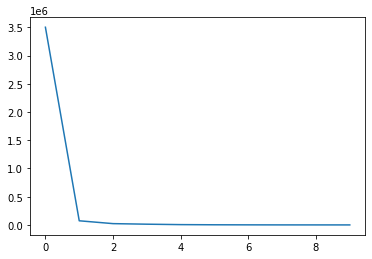

In [ ]:
df2['emoji_count'].value_counts().nlargest(10).plot()

### 3b) Composite feature for emojis
Using the previously built emoji features, create a composite column that identifies if any of the previous emoji columns have a 1 then 1.

In [ ]:
#re-run this cell without white space before 'double'!
df2['emoji_troll']= df2.emoji_text.apply(lambda x: 1 if re.findall(r'flag: United States|check mark|police car light|double exclamation mark|raised fist|collision|prohibited', x) else 0)

In [ ]:
df2.groupby(['class'])['emoji_troll'].value_counts()

class     emoji_troll
Troll     0              2105581
          1                11285
Verified  0              1505248
          1                 2780
Name: emoji_troll, dtype: int64

In [ ]:
#Export as 03_eda_w_emojis2
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_after_03_eda_emojis2.parquet.gz'
df2.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### Import df3 with both emoji encodings

In [ ]:
#import
#df with emoji binary encoding and composite column
df3 = pd.read_parquet(file_folder +'data_after_03_eda_emojis2.parquet.gz')

#### 3c) Region
Breaking out region into a binary category for Unknown location. Imputing nulls as Unknown. If null or unknown then 1 else 0.

In [ ]:
#fill na with "Unknown"
df3['region'] = df3['region'].fillna('Unknown')

In [ ]:
df3['region'].value_counts()

United States                     1906588
Unknown                            421147
Washington, DC                      95828
New York, NY                        67175
United Kingdom                      26881
                                   ...   
Stade Jean-Bouin, Paris                 1
Bergen County, New Jersey, USA          1
Fort Smith, AR                          1
BOS, MA ➡️ DSM, IA ➡️ TPA, FL           1
Dijon, France                           1
Name: region, Length: 35446, dtype: Int64

In [ ]:
#examine class ratios of Unknown region
df_unknown= df3.loc[df3['region'] =='Unknown',['class']]
df_unknown['class'].value_counts()

Troll       242089
Verified    179058
Name: class, dtype: int64

In [ ]:
#create new feature 'unknown_location' using 1 if region = 'Unknown' else 0
df3['unknown_location']= df3['region'].apply(lambda x: 1 if x =='Unknown' else 0)
df3['unknown_location'].value_counts()

0    3203747
1     421147
Name: unknown_location, dtype: int64

#### 3d) Multi_Author: 
Users that have multiple `Author` entries (i.e. usernames) for each `External_author_id` field essentially have changed their usernames on a single account. If a user has > 1 author name the binary feature will be positive (1) else 0.


In [ ]:
print('Unique author names:',df3['author'].nunique())
print('Unique author ID#:', df3['external_author_id'].nunique())


Unique author names: 142270
Unique author ID#: 141959
Authors with more than one name per ID 311


In [ ]:
#Extract the authors with > 1 author name per external author id
multi= df3.groupby('external_author_id')['author'].nunique().nlargest(42)
print(multi)
multi_authors = multi.index
print(multi_authors)

external_author_id
889000000000000000    59
895000000000000000    42
753000000000000000    27
890000000000000000    21
868000000000000000    19
898000000000000000    17
751000000000000000    16
892000000000000000    16
891000000000000000    14
866000000000000000    13
867000000000000000    13
844000000000000000     9
843000000000000000     7
871000000000000000     7
893000000000000000     7
854000000000000000     6
837000000000000000     5
838000000000000000     5
839000000000000000     5
731000000000000000     4
750000000000000000     3
802000000000000000     3
816000000000000000     3
853000000000000000     3
865000000000000000     3
870000000000000000     3
901000000000000000     3
2753146444             2
2912754262             2
4224912857             2
44278933               2
703000000000000000     2
704000000000000000     2
719000000000000000     2
762000000000000000     2
804000000000000000     2
831000000000000000     2
846000000000000000     2
888000000000000000     2
902000

In [ ]:
#show user with most author names
df3[df3['external_author_id']=='889000000000000000']['author'].unique()

<StringArray>
[     'ABBYLOPTRT',     'ABISADMASST',      'ADALESTRTM',    'ADELIINESTRT',
      'ADELISTRTT',       'ADLEESTTT',       'ADLEESWOD',      'AGNESMLTRT',
      'AGNESSTRYT',       'ALAXXATRT',    'ALBELITATRTS',     'ALEMICHLESS',
      'ALESISTRTT',       'AMBAASTRT',      'AMBBERTHTT',        'AMYYSSTS',
      'ANEELSSTRT',     'APRIILDTRUT',    'RACHLEESTRMT',      'REBEESLYSS',
       'RELIISTRT',       'SAVAJENAT',    'SCARLEESTRUT', 'SCARLETTHOWAR15',
       'SEREESSTT',      'SKYYLASRRT',      'TAYYSSTRUT',       'THAASLITT',
       'TRINITTXS',      'VIOLAASTRT',       'AVEERTEST',         'BAAILST',
       'BAMBISMUT',     'BEELLASTRTT',       'BONIIISTP',      'BROOZLEETR',
       'CARREDTRT',     'CHHOLESSSTR',      'CHISTISSST',       'DANNIILST',
       'ELLISSTRT',     'EMILLLYSTRU',       'EVASSLTRT',       'HARERETRT',
      'HAYDELYYST',       'JAAMISSTR',       'KAYYLYSST',       'LAREELIZT',
        'LILYYTYY',       'LOSSDAYTR',      'LUSCBELYST',     

In [ ]:
len(multi_authors)

41

In [ ]:
#save as pandas dataframe and export as csv
multi_author_df = pd.DataFrame(multi_authors, columns=['ID'])
multi_author_df.to_csv('/content/gdrive/MyDrive/Grad School/DSCI592/data/multi_author_df.csv', index=False)

In [ ]:
#create new feature column that represents if user has multi usernames (1) else 0
df3['multi_authors']= df3['external_author_id'].apply(lambda x: 1 if x in multi_authors else 0 )

In [ ]:
df3['multi_authors'].value_counts()

0    3346597
1     278297
Name: multi_authors, dtype: int64

In [ ]:
df3.groupby('class')['multi_authors'].value_counts()

class     multi_authors
Troll     0                1838572
          1                 278294
Verified  0                1508025
          1                      3
Name: multi_authors, dtype: int64

In [ ]:
df3[df3['external_author_id']=='44278933']['author'].value_counts()

theon9citizen    2
tocsg            1
Name: author, dtype: Int64

In [ ]:
#Export as 06_data_engineered1
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

### 3c. Addl Features tbd.

In [ ]:
df3['emoji_count'].nlargest(25)

2902076    121
1094396    118
1084372    116
2685330    116
1101196    108
1094400    107
3323722    105
3117295     93
3150359     93
3076323     87
1093775     85
1085610     72
2894921     70
2717717     68
2795004     66
1079250     61
2877942     58
34496       57
176550      57
600437      57
750656      57
836875      57
858575      57
907445      57
919066      57
Name: emoji_count, dtype: int64

In [ ]:
df3.groupby('class')['emoji_count'].nlargest(15)

class            
Troll     1094396    118
          1084372    116
          1101196    108
          1094400    107
          1093775     85
          1085610     72
          1079250     61
          34496       57
          176550      57
          600437      57
          750656      57
          836875      57
          858575      57
          907445      57
          919066      57
Verified  2902076    121
          2685330    116
          3323722    105
          3117295     93
          3150359     93
          3076323     87
          2894921     70
          2717717     68
          2795004     66
          2877942     58
          3574021     57
          2846044     51
          3506514     48
          3530381     48
          2794217     47
Name: emoji_count, dtype: int64

In [ ]:
df3.loc[1094396]

external_author_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### 4 Refining dataset for English Only Model

In [ ]:
len(df3)

3624894

In [ ]:
df3['language'].value_counts()

en     3623140
fr         397
tl         308
es         304
de         157
nl         117
in          83
pt          65
it          58
da          56
et          48
ht          43
eu          24
ca          18
sv          16
no          13
pl          12
cy          12
lt           4
tr           4
vi           4
lv           3
hu           2
cs           1
ko           1
hi           1
ro           1
und          1
zxx          1
Name: language, dtype: int64

In [ ]:
#save as en_df for English only tweets
en_df = df3[df3['language']=='en']
len(en_df)

3623140

In [ ]:
en_df['account_category'].value_counts()

Verified_User    1470028
RightTroll        704953
NewsFeed          596593
LeftTroll         422141
HashtagGamer      236091
Commercial        112580
Unknown            43191
NonEnglish         26562
Fearmonger         11001
Name: account_category, dtype: int64

In [ ]:
en_df=en_df[en_df['account_category']!='NonEnglish']
len(en_df)

3596578

In [ ]:
en_df['account_category'].value_counts()

Verified_User    1470028
RightTroll        704953
NewsFeed          596593
LeftTroll         422141
HashtagGamer      236091
Commercial        112580
Unknown            43191
Fearmonger         11001
NonEnglish             0
Name: account_category, dtype: int64

In [ ]:
#Export as 06_data_engineered_en
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_en.parquet.gz'
en_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')